In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import cv2

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn import functional as F
from torchvision.utils import make_grid

###  1. Load Image & Labels

(-0.5, 999.5, 999.5, -0.5)

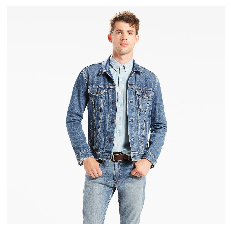

In [2]:
image_path = 'images/test08.jpg'
image = Image.open(image_path)
labels = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
classes = {int(key):value for (key, value) in requests.get(labels).json().items()}
plt.imshow(image)
plt.axis('off')

### 2. Preprocess Image data

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
normalise = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])
my_image = normalise(preprocess(image)).unsqueeze(0).cuda()

### 3. Load Model

In [4]:
model = models.densenet161(pretrained=True).cuda()
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

#### 4. Feature Extraction & Prediction

In [5]:
features_blobs = []
def hook_feature(module, input, output):
    return features_blobs.append(output.data.cpu().numpy())

model._modules.get('features').register_forward_hook(hook_feature)
params = list(model.parameters())
weight_to_softmax = np.squeeze(params[-2].cpu().data.numpy())

output = model(my_image)
h_x = F.softmax(output, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.cpu().numpy()
idx = idx.cpu().numpy()

### 5. Class Activation Mapping

In [6]:
feature_conv = features_blobs[0]
class_idx = idx[0]
B, C, H, W = feature_conv.shape

cam_mat = feature_conv.reshape((C, H*W))
cam_mat = weight_to_softmax[class_idx].dot(cam_mat)
cam_mat = cam_mat.reshape(H, W)
cam_mat = cam_mat - np.min(cam_mat)
cam_mat = cam_mat / np.max(cam_mat)
cam_mat= np.uint8(cam_mat * 255)

### 6. Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'jean, blue jean, denim -> (99.80%)')

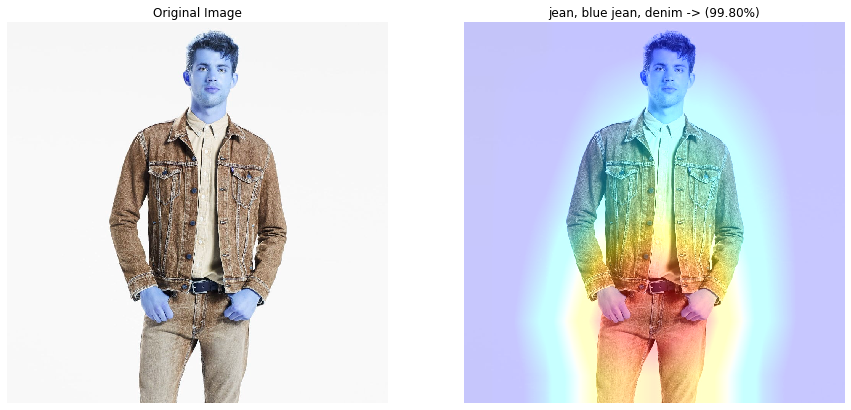

In [8]:
ori_image = cv2.imread(image_path)
height, width, _ = ori_image.shape
heatmap = cv2.applyColorMap(cv2.resize(cam_mat,(width, height)), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
cam_image =  heatmap * 0.4 + ori_image * 0.8

fig = plt.figure()
plt.rcParams["figure.figsize"] = (15, 15)

a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(ori_image)
plt.title('Original Image')
plt.axis('off') 

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(cam_image/255)
plt.axis('off') 
plt.title('{} -> ({:.2f}%)'.format(classes[idx[0]], probs[0]*100))